# Exploration

In this notebook we explore a little how our data looks like, we need this to find out which preprocessing steps are necessary to make our detection models work.

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

we will use one portion of the dataset for this exploration, all portions should have the same structure

In [2]:
DATA_DIR = os.path.join('train', 'Venice-2')
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'gt', 'gt.txt')
IMAGES_DIR = os.path.join(DATA_DIR, 'img1')

let us explore the annotations

In [40]:
df = pd.read_csv(ANNOTATIONS_FILE, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,1,1,415,449,129,269,1,-1,-1,-1
1,1,2,581,443,97,269,1,-1,-1,-1
2,1,3,1347,415,153,377,1,-1,-1,-1
3,1,4,1429,423,161,339,1,-1,-1,-1
4,1,5,621,459,79,193,1,-1,-1,-1


we know that columns 2 to 5 are bounding box coordinates

In [32]:
for col in df.columns:
    msg = "On column {} we found {} unique values"
    print(msg.format(col, len(df[col].unique())))
    
print("-------------------------------------------")

img_list = sorted(os.listdir(IMAGES_DIR))
msg = "Number of images: {}"
print(msg.format(len(img_list)))

On column 0 we found 600 unique values
On column 1 we found 26 unique values
On column 2 we found 843 unique values
On column 3 we found 66 unique values
On column 4 we found 185 unique values
On column 5 we found 337 unique values
On column 6 we found 1 unique values
On column 7 we found 1 unique values
On column 8 we found 1 unique values
On column 9 we found 1 unique values
-------------------------------------------
Number of images: 600


since columns 6 to 9 do not change over the entire dataset we will just ignore them; however it's maybe because I am too lazy to look for why those values are there, perhaps some one else will find out and let me know.

In [41]:
df = df.drop(columns = [6, 7, 8, 9])
df.head()

,0,1,2,3,4,5
0,1,1,415,449,129,269
1,1,2,581,443,97,269
2,1,3,1347,415,153,377
3,1,4,1429,423,161,339
4,1,5,621,459,79,193


On the other hand, we see 600 unique values for colum 0 and 600 images available, so we can safely assume that the first column in the annotations file correspond to the image we are looking. Moreover, we conclude that column 1 contains the id of the bounding boxes in the training data.

Let's load a particular image, just for the sake of exploration

In [104]:
def get_bounding_boxes(df, img_id):
    annotation = df[df[0] == img_id].values.tolist()
    boxes = {
        annot[1]:(annot[2], annot[3], annot[4], annot[5])
        for annot in annotation
    }
    return boxes

File: 000001.jpg,
 Bounding boxes:
 {1: (415, 449, 129, 269), 2: (581, 443, 97, 269), 3: (1347, 415, 153, 377), 4: (1429, 423, 161, 339), 5: (621, 459, 79, 193), 10: (473, 453, 103, 261), 16: (541, 459, 43, 99), 18: (1365, 429, 49, 139), 19: (1249, 443, 43, 105), 20: (1015, 431, 47, 119), 22: (975, 457, 37, 79)}
Shape of image: (1080, 1920, 3)


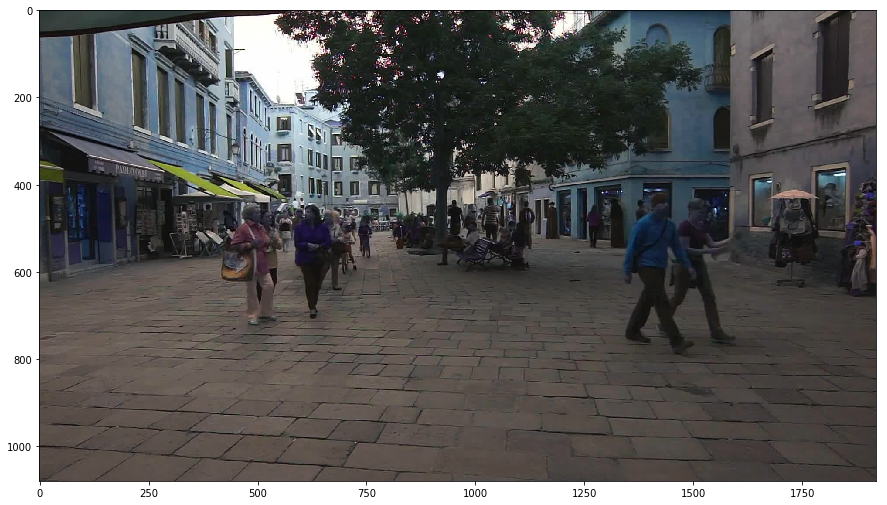

In [105]:
msg = "File: {},\n Bounding boxes:\n {}"
fname = img_list[0]
img_id = int(fname.split('.')[0])
boxes = get_bounding_boxes(df, img_id)
print(msg.format(fname, boxes))

img = cv2.imread(
    os.path.join(IMAGES_DIR, img_list[0]),
    cv2.IMREAD_COLOR
)
print("Shape of image: {}".format(img.shape))
plt.figure(figsize=(15,15))
plt.imshow(img)

well...that is not very informative, let us try to draw the bounding boxes on top of the image. Based on the values on the bounding boxes I assume that the bounding boxes are in (x, y, w, h) format.

In [106]:
def draw_one_bb(img, x, y, w, h):
    """
    (x,y) are the top left coordinates and
    w and h are the width and height respectively.
    """
    img = img.copy()  
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
    return img

In [107]:
def draw_all_bb(img, boxes_dict):
    
    for box_id, (x, y, w, h) in boxes_dict.items():
        img = draw_one_bb(img, x, y, w, h)
        
    return img

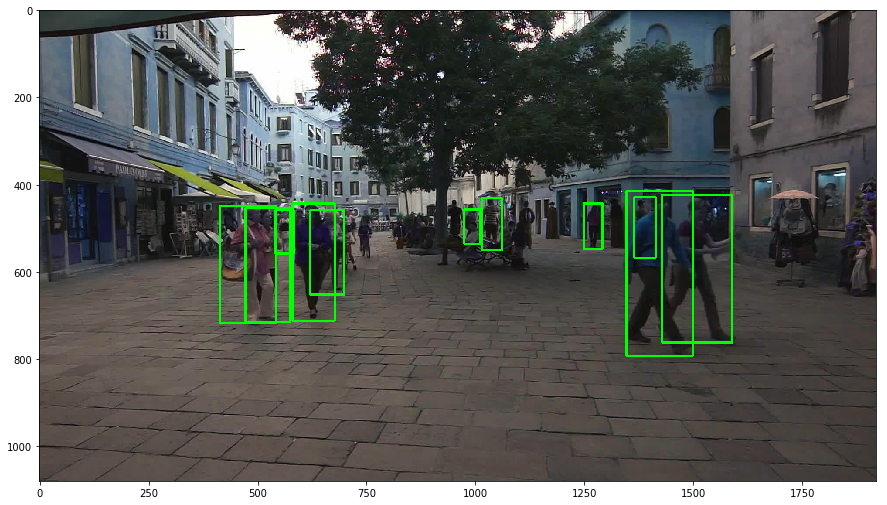

In [108]:
plt.figure(figsize=(15,15))
plt.imshow(draw_all_bb(img, boxes))

now we can safely say that we understand our data, at least our images and annotations.

Finally, since we know images are sequential frames, we may want to play a video with all boxes. This may be useful to assess the quality of a detection model, but is also fun!

In [114]:
def make_video_with_bb(df, img_list, fpath='test_video.avi', fps=40, shape=(1920, 1080)):
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter(fpath, fourcc, fps, shape)
    
    msg = "Processing: {}, with shape: {}"
    for fname in img_list:
        
        img_id = int(fname.split('.')[0])
        boxes = get_bounding_boxes(df, img_id)
        img = cv2.imread(
            os.path.join(IMAGES_DIR, fname),
            cv2.IMREAD_COLOR
        )
        
        print(msg.format(fname, img.shape), end='\r')
        #mg = cv2.resize(img, shape)
        img = draw_all_bb(img, boxes)
        
        out.write(img)
    out.release()

In [115]:
make_video_with_bb(df, img_list)

Go and play the video!